In [ ]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=bd61102cf525475f6dba8ba4df807b57d70d6430a7ca3bdd85380e3f9ccd0c81
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision
import torchvision.models as models
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time
from torch.utils.data import DataLoader
import torch.utils.data
from torch.utils.data import Subset
import random

import wandb 
wandb.login()
import math



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
     transforms.Normalize(0.5,0.5)])


batch_size = 128
trainset = torchvision.datasets.MNIST(root='mnist', train=True,
                                        download=True, transform=transform)




train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
#Training Data

def get_train(batch_size):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  return trainloader



# Validation Data


def get_val(batch_size):
  valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
  return valloader




#Testing Data

testset = torchvision.datasets.MNIST(root='Mnist', train=False,
                                       download=True, transform=transform)



testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




100%|██████████| 9912422/9912422 [00:00<00:00, 239178673.30it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 125269590.30it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68017578.99it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20957677.41it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 235463052.86it/s]

Extracting Mnist/MNIST/raw/train-images-idx3-ubyte.gz to Mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 19049487.94it/s]


Extracting Mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71846698.97it/s]


Extracting Mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6397088.24it/s]

Extracting Mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Mnist/MNIST/raw



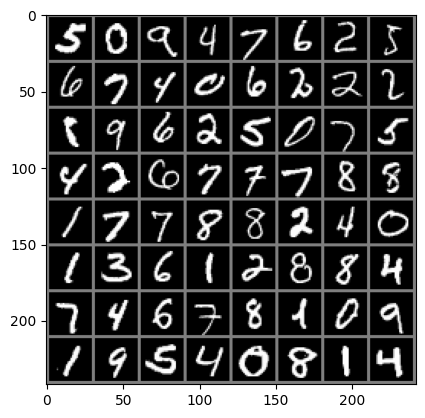

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(get_train(64))
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(256, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
lenet = LeNet5(10)
model = lenet
model = model.to(device)

In [ ]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [ ]:
def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

In [ ]:
# Launch 3 experiments, trying different learning rates and batch sizes
for _ in range(3):
    lenet = LeNet5(10)
    model = lenet
    model = model.to(device)


    # 🐝 initialise a wandb run
    wandb.init(
        project="Mnist DLOps Project",
        config={
            "activation": random.choice(['ReLU','LeakyReLU','Tanh']),
            "optimizer" : random.choice(["Adam","SGD","RMSprop"]),
            "epochs": 5,
            "batch_size": 128,
            "lr": 1e-3,

        
            })
    # Copy your config 
    config = wandb.config

    print("\n The HyperParameters Choosen are : \n  optimizer function :   ", config.optimizer," \n Activation function : ", config.activation,"\n \n")

    

    # Get the data
    train_dl = get_train(batch_size=config.batch_size)
    valid_dl = get_val(batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)
    
    model = model

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    if config.optimizer == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

    elif config.optimizer == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    
    else:
      optimizer = torch.optim.RMSprop(model.parameters(), lr=config.lr)



    if config.activation == "Tanh":
      # Create a list of modules that need to be replaced
      replace_modules = []
      for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
          replace_modules.append(name)


      # Replace the ReLU modules with tanh outside the loop
      for name in replace_modules:
        setattr(model, name, nn.Tanh())
      model = model.to(device)
      

    elif config.activation =="LeakyReLU":
      # Create a list of modules that need to be replaced
      replace_modules = []
      for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
          replace_modules.append(name)


      # Replace the ReLU modules with LeakyReLU outside the loop
      for name in replace_modules:
        setattr(model, name, nn.LeakyReLU(inplace=True))
      
      model = model.to(device)
    
    else :
      pass

    

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            example_ct += len(images)
            metrics = {"train/train_loss": train_loss, 
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                       "train/example_ct": example_ct}
            
            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
                
            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # 🐝 Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss, 
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})
        
        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run 
    wandb.finish()


 The HyperParameters Choosen are : 
  optimizer function :    SGD  
 Activation function :  LeakyReLU 
 

Train Loss: 2.262, Valid Loss: 2.245621, Accuracy: 0.29
Train Loss: 2.184, Valid Loss: 2.173319, Accuracy: 0.48
Train Loss: 2.058, Valid Loss: 2.068041, Accuracy: 0.55
Train Loss: 1.903, Valid Loss: 1.915163, Accuracy: 0.60
Train Loss: 1.669, Valid Loss: 1.697361, Accuracy: 0.65


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,████████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▂▂▁▁
val/val_accuracy,▁▅▆▇█
val/val_loss,█▇▆▄▁
test_accuracy,0.8
train/epoch,5.0
train/example_ct,240000
train/train_loss,1.66936
val/val_accuracy,0.64783
val/val_loss,1.69736



 The HyperParameters Choosen are : 
  optimizer function :    Adam  
 Activation function :  LeakyReLU 
 

Train Loss: 0.075, Valid Loss: 0.069652, Accuracy: 0.98
Train Loss: 0.012, Valid Loss: 0.053343, Accuracy: 0.98
Train Loss: 0.123, Valid Loss: 0.046936, Accuracy: 0.98
Train Loss: 0.039, Valid Loss: 0.036455, Accuracy: 0.99
Train Loss: 0.004, Valid Loss: 0.041759, Accuracy: 0.99


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▃▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁
val/val_accuracy,▁▄▅█▇
val/val_loss,█▅▃▁▂
test_accuracy,0.8
train/epoch,5.0
train/example_ct,240000
train/train_loss,0.00371
val/val_accuracy,0.98642
val/val_loss,0.04176



 The HyperParameters Choosen are : 
  optimizer function :    SGD  
 Activation function :  LeakyReLU 
 

Train Loss: 2.222, Valid Loss: 2.230236, Accuracy: 0.26
Train Loss: 2.153, Valid Loss: 2.158464, Accuracy: 0.47
Train Loss: 2.020, Valid Loss: 2.050930, Accuracy: 0.58
Train Loss: 1.852, Valid Loss: 1.890574, Accuracy: 0.63
Train Loss: 1.694, Valid Loss: 1.666333, Accuracy: 0.67


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,███████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▂▃▂▂▁▁
val/val_accuracy,▁▅▆▇█
val/val_loss,█▇▆▄▁
test_accuracy,0.8
train/epoch,5.0
train/example_ct,240000
train/train_loss,1.69418
val/val_accuracy,0.66658
val/val_loss,1.66633
